In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from math import sqrt

from tqdm import tqdm

In [2]:
batch_size = 64
num_classes = 10
learning_rate = 10e-3
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
#Loading the dataset and preprocessing
train_dataset = torchvision.datasets.MNIST(root = './data',
                                           train = True,
                                           transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1307,), std = (0.3081,))]),
                                           download = True)


test_dataset = torchvision.datasets.MNIST(root = './data',
                                          train = False,
                                          transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1325,), std = (0.3105,))]),
                                          download=True)


train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = False)


test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = 64, # TEST BATCH SIZE
                                           shuffle = False)

In [4]:
#Defining the convolutional neural network
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(400, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [5]:
LeNet = LeNet5(num_classes).to(device)

#Setting the loss function
cost = nn.CrossEntropyLoss()

#Setting the optimizer with the model parameters and learning rate
optimizer = torch.optim.Adam(LeNet.parameters(), lr=learning_rate)

#this is defined to print how many steps are remaining when training
total_step = len(train_loader)

In [6]:
# LOAD FROM SAVED FILE
LeNet = torch.load('LeNet.pth')
LeNet.eval()

LeNet5(
  (layer1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=400, out_features=120, bias=True)
  (relu): ReLU()
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)

https://federicozanotti.github.io/2021-09-16-frank-wolfe/

In [7]:
def flatten_data(batched_data):
    b, _, d, _ = batched_data.shape
    return batched_data.view(b, 1, d*d)

def unflatten_data(flattened_data, d):
    b, _ = flattened_data.shape[:2]
    return flattened_data.view(b, 1, d, d)

In [8]:
def F_torch(x, y_true, model):
    """
    Loss function for all the examples

    Input:
    - x: images [batch_size, channels, height, width]
    - y_true: true labels of the images [batch_size]
    - model: the PyTorch model used for prediction

    Returns:
    - Loss: computed loss
    """

    # Predict class scores
    f = model(x)
    
    # Gather the scores for the correct class
    f_yi = torch.gather(f, 1, y_true.view(-1, 1)).squeeze()
    
    # Create a mask for the correct class, setting them to a very small value
    mask = torch.arange(f.size(1)).expand(f.size(0), f.size(1)).to(y_true.device)  # This creates a matrix of size batch_size x num_classes
    mask = mask != y_true.view(-1, 1)  # This gives a mask where the correct class for each example is set to False
    
    # Using the mask, set scores of the correct class to a very low value so they won't be selected
    f_j = torch.where(mask, f, torch.tensor(-1e10).to(f.device)).max(dim=1).values
    
    # Compute the loss and apply the ReLU operation
    loss = torch.relu(f_yi - f_j)
    
    return loss.mean()

def RandGradEst(x, y_true, v, d, model):
    """
    Two-point (gaussian) random gradient estimator

    Input:
    - x: image [batch_size, channels, height, width]
    - y_true: true labels of the images [batch_size]
    - v: smoothing parameter
    - d: dimensionality of the image (typically, channels x height x width)
    - model: the PyTorch model used for prediction inside the loss function F_torch

    Returns:
    - Gradient estimate
    """
    device = x.device  # Get the device of the input tensor (either CPU or CUDA)

    # Create a tensor with standard normal values
    u = torch.randn((1, d, d), device=device)

    # Compute the F function values for the two points
    F_plus = F_torch(x + v*u, y_true, model)
    F_ = F_torch(x, y_true, model)

    # Calculate the gradient estimate
    grad_estimate = (d/v)*(F_plus - F_)*u

    return grad_estimate

def Avg_RandGradEst(x, y_true, q, v, d, model):
    """
    Averaged (gaussian) random gradient estimator

    Input:
    - x: image [batch_size, channels, height, width]
    - y_true: true labels of the images [batch_size]
    - q: number of random directions
    - v: smoothing parameter
    - d: dimensionality of the image (typically, channels x height x width)
    - model: the PyTorch model used for prediction inside the F_torch function

    Returns:
    - Averaged gradient estimate
    """
    device = x.device  # Get the device of the input tensor (either CPU or CUDA)

    # Create a tensor with standard normal values for all q directions
    u = torch.randn((q, d, d), device=device)

    # Compute the F function value for the original point
    F_ = F_torch(x, y_true, model)
    
    g = 0
    for j in range(q):
        F_plus = F_torch(x + v*u[j], y_true, model)
        g = g + (F_plus - F_)*u[j]

    # Calculate the averaged gradient estimate
    avg_grad_estimate = (d/(v*q))*g

    return avg_grad_estimate

def stop_attack(x, y_true, model):
    with torch.no_grad():
        # Assuming the model outputs raw logits
        logits = model(x)
        success = torch.argmax(logits, dim=1)
        return torch.sum(success == y_true).item() == 0


In [10]:
def F_Par_torch(x, y_true, model):
    """
    Loss function for only one example

    Input:
    - x: image [batch_size, channels, height, width]
    - y_true: true label of the image [batch_size]

    Returns:
    - Computed loss values
    """
    # Model prediction
    f = model(x)
    
    # Gather the predictions for the true class label
    f_yi = torch.gather(f, 1, y_true.view(-1, 1)).squeeze()
    
    # Mask out the true class labels
    f_j_values, _ = torch.max(f + (y_true.view(-1, 1) == 1).float() * -1e10, dim=1)

    return torch.clamp(f_yi - f_j_values, min=0)

def Avg_RandGradEst_Par(x, y_true, q, v, d, model):
    """
    Averaged (gaussian) random gradient estimator in parallel

    Input:
    - x: image [batch_size, channels, height, width]
    - y_true: true labels of the images [batch_size]
    - q: number of random directions
    - v: smoothing parameter
    - d: dimensionality of the image (typically, channels x height x width)
    
    Returns:
    - Averaged gradient estimate
    """
    device = x.device  # Get the device of the input tensor (either CPU or CUDA)
    
    # Generate random directions
    u = torch.randn((q, d), device=device)

    # Compute the F function value for the original point
    F_ = F_Par_torch(x, y_true, model).mean()

    # Create tensors for q directions and compute the difference
    x_par_plus = (x.unsqueeze(0) + v*u.unsqueeze(1)).view(-1, *x.shape[1:])
    diff = F_Par_torch(x_par_plus, y_true.repeat(q), model) - F_

    # Compute the gradient estimate
    g = torch.sum((diff.view(q, -1) / v).unsqueeze(2) * u.unsqueeze(1), dim=0)

    return (d/(q*v))*g.mean(dim=0)


In [9]:
from torch.utils.data import DataLoader

# Create an unbatched DataLoader
test_grabber = DataLoader(test_dataset, batch_size=1, shuffle=False)

def get_data(n, c, test_loader):
    """
    Return x, x_ori, y_true_in.
    """
    x_ori, y_true_in = extract_images(n, c, test_loader)
    x = x_ori.clone()
    return x, x_ori, y_true_in

def extract_images(n, c, test_loader):
    """
    Extract some images of the same class from a DataLoader.

    Input:
    - n: number of images to extract
    - c: label
    - test_loader: DataLoader to extract images from
    """
    x_extr = []
    y_extr = []
    
    for x, y in test_loader:
        if y.item() == c:
            x_extr.append(x)
            y_extr.append(y)
            
        if len(x_extr) == n:
            break

    return torch.stack(x_extr).view((n,1,32,32)), torch.stack(y_extr)


In [10]:

def ZOFW(N, d, s, m_k, x, y_true_in, model, v=-1, alpha=-1, B=1, verbose=True, clip=False):
    device = x.device  # Assuming x is already a PyTorch tensor

    if v == -1:
        v = sqrt(2 / (N * (d + 3)**3))
    if alpha == -1:
        alpha = 1 / torch.sqrt(torch.tensor(N, dtype=torch.float32))

    x_ori = x.clone()
    loss_ZSCG = []
    perturbations = []
    loss_ZSCG.append(F_torch(x, y_true_in, model))

    if verbose:
        print("Epoch:", 0, "Loss:", F_torch(x_ori, y_true_in, model).item(), "Distortion:", torch.max(torch.abs(x - x_ori)).item())
    for k in range(N):
        v_k = 0
        for i in tqdm(range(x.shape[0]), disable= not verbose):
            v_k += Avg_RandGradEst(x[i:i+1], y_true_in[i:i+1], m_k, v, 32, model)
            #v_k += Avg_RandGradEst_Par(x[i:i+1], y_true_in[i:i+1], m_k, v, d, model)

        v_k = (1 / x.shape[0]) * v_k

        x_k = -s * torch.sign(v_k) + x_ori 
        x = (1 - alpha) * x + alpha * x_k
        if clip:
            x = x_ori + torch.clamp((x - x_ori), 0, 1)
        perturbations.append(x)
        loss_ZSCG.append(F_torch(x, y_true_in, model).item())
        if verbose:
            print("-"*100)
            print("Epoch:", k+1, "Loss:", loss_ZSCG[k], "Distortion:", torch.max(torch.abs(x - x_ori)).item())
        if stop_attack(x, y_true_in, model):  # Assuming this function handles PyTorch tensors
            print("Attack successful! stopping computation...")
            return loss_ZSCG, x

    ZSCG_x_perturbated = x
    print("ZSCG Final loss =", loss_ZSCG[-1])
    return loss_ZSCG, ZSCG_x_perturbated, perturbations


In [11]:
T = 100 # EPOCHS
n = 100 # number of examples to attack
d = 32*32 # dimension
q = 30 # number of times to sample gradient
 # samples to run on [b,1,d] NOTE: this is flattened
x, _, y_true = get_data(n, 4,test_grabber)
s = 0.1 # step size
#loss_Z, x_Z, p1=SZOFW(T, d, 0.1, q, x, y_true, LeNet, verbose=True)
#ZSCG(T, d, 0.1, q, x, y_true_in, LeNet)

(-0.5, 31.5, 31.5, -0.5)

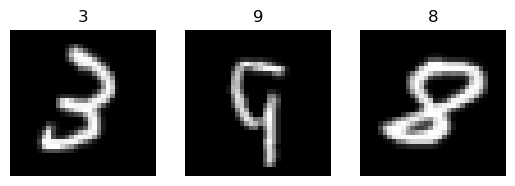

In [36]:
fig, axs = plt.subplots(1,3)
axs[0].imshow(a[-1][0].squeeze().detach().numpy(),cmap='gray')
axs[0].set_title(l[-1].item())
axs[0].axis('off')
axs[1].imshow(a[-2][0].squeeze().detach().numpy(),cmap='gray')
axs[1].axis('off')
axs[1].set_title(l[-2].item())
axs[2].imshow(a[-3][0].squeeze().detach().numpy(),cmap='gray')
axs[2].set_title(l[-3].item())
axs[2].axis('off')

In [13]:
out = True
for a,l in test_loader:
    if out:
        print(l)
        #print(flatten_data(a).shape)
        #print("loss test")
        #print(F_torch(a,l,LeNet))
        #print("grad test")
        #print(RandGradEst(a,l,0.3,32,LeNet))
        #print(Avg_RandGradEst(a,l,30,0.3,32,LeNet).shape)
        print(CoordGradEst_torch(a[0], l[0], 0.3, 32, LeNet))
        #print('Avg_RandGradEst_Par')
        #print(Avg_RandGradEst_Par(a, l, 30, 0.3, 32, LeNet).shape)
    out = False

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3])


NameError: name 'CoordGradEst_torch' is not defined

In [22]:
# OLD
def ACC_ZOFW(T, d, s, q,n, x, y_true_in, model, v=-1, alpha=-1, B=1, verbose=True, clip=False, GE = "uni"):
    """"
    Employs a varience reduction technique to reduce the query capacity
    T, int: Number of Epochs
    d, int: dim along one side of example. Shape: (d, d)
    q, int: mini-batch size
    x, input data of shape ()
    """
    device = x.device  # Assuming x is already a PyTorch tensor
    if GE == "uni": 
        grad_est = Avg_RandGradEst
    elif GE == "coo":
        grad_est = Avg_RandGradEst
    if v == -1:
        v = sqrt(2 / (T * (d + 3)**3))
    if alpha == -1:
        alpha = 1 / torch.sqrt(torch.tensor(T, dtype=torch.float32))

    x_ori = x.clone()
    loss_ZSCG = []
    perturbations = []
    loss_ZSCG.append(F_torch(x, y_true_in, model))

    if verbose:
        print("Epoch:", 0, "Loss:", F_torch(x_ori, y_true_in, model).item(), "Distortion:", torch.max(torch.abs(x - x_ori)).item())
    for t in range(T):
        v_t = 0
        if mod(t,q) == 0:
            for i in range(b1):
                v_t = v_t + grad_est()
            v_t = v_t / b1
        else:
            #for i in np.random.rand(0,x.shape[0], b2):
            for i in range(0, ): 
                
        '''
        for i in tqdm(range(x.shape[0]), disable= not verbose):
            v_k += Avg_RandGradEst(x[i:i+1], y_true_in[i:i+1], m_k, v, 32, model)
            #v_k += Avg_RandGradEst_Par(x[i:i+1], y_true_in[i:i+1], m_k, v, d, model)
        '''
        v_t = (1 / x.shape[0]) * v_t

        x_t = -s * torch.sign(v_t) + x_ori 
        x = (1 - alpha) * x + alpha * x_t
        if clip:
            x = x_ori + torch.clamp((x - x_ori), 0, 1)
        perturbations.append(x)
        loss_ZSCG.append(F_torch(x, y_true_in, model).item())
        if verbose:
            print("-"*100)
            print("Epoch:", t+1, "Loss:", loss_ZSCG[t], "Distortion:", torch.max(torch.abs(x - x_ori)).item())
        if stop_attack(x, y_true_in, model):  # Assuming this function handles PyTorch tensors
            print("Attack successful! stopping computation...")
            return loss_ZSCG, x

    ZSCG_x_perturbated = x
    print("ZSCG Final loss =", loss_ZSCG[-1])
    return loss_ZSCG, ZSCG_x_perturbated, perturbations


IndentationError: expected an indented block after 'for' statement on line 34 (3790393094.py, line 36)

In [14]:
def e(i, d, device):
    """
    Orthogonal basis vector in PyTorch

    Input:
    - i: index
    - d: dimensions
    - device: the device (CPU or CUDA) to place the tensor on

    Returns:
    - PyTorch tensor of shape [1, d, d]
    """
    ei = torch.zeros(1, d, d, device=device)
    ei[0, i//d, i%d] = 1
    return ei

def CoordGradEst_Par(x, y_true, mu, d, model):
    """
    Coordinate-wise gradient estimator in parallel using PyTorch.

    Input:
    - x: image of shape [1, d, d]
    - y_true: true scalar label of the image
    - mu: smoothing parameter
    - model: PyTorch model used for predictions
    """
    device = x.device  # Get the device (CPU or CUDA) of the tensor

    # Generate x_par_plus and x_par_minus using list comprehension
    x_par_plus = torch.stack([x + mu*e(j, d, device) for j in range(d*d)])
    x_par_minus = torch.stack([x - mu*e(j, d, device) for j in range(d*d)])

    diff = F_torch(x_par_plus, y_true, model) - F_torch(x_par_minus, y_true, model)
    print(x_par_plus.shape)

    q = 0
    for j in range(d):
        q = q + diff[j] * e(j, d, device)

    return (1 / (2 * mu)) * q

In [15]:
import torch.nn.functional as F

def F_Par_torch(x, y_true, model):
    """
    PyTorch version of the F_Par loss function for only one example.

    Input:
    - x: PyTorch tensor of the image of shape [batch_size, 1, d, d]
    - y_true: PyTorch tensor of true labels of the images of shape [batch_size]
    - model: a PyTorch model for predictions

    Returns:
    - PyTorch tensor of the calculated losses for each image in the batch
    """
    device = x.device  # Get the device of the input tensor (either CPU or CUDA)

    # Getting model predictions
    logits = model(x)
    
    # Calculate f_yi
    # Using gather here to extract the scores at the true class indices
    f_yi = logits.gather(1, y_true.view(-1, 1)).squeeze()

    # Calculate f_j
    # Creating a mask to set true class logits to a very small value so they're not selected in the max operation
    mask = torch.ones_like(logits) * 1e10
    mask.scatter_(1, y_true.view(-1, 1), -1e10)
    f_j, _ = torch.max(logits - mask, dim=1)

    # Compute the final loss values per example
    losses = torch.where(f_yi-f_j > 0, f_yi-f_j, torch.tensor(0.0, device=device))
    
    return losses


In [16]:
def CoordGradEst_torch(x, y_true, mu, d, model):
    """
    PyTorch version of the coordinate-wise gradient estimator.

    Input:
    - x: PyTorch tensor of the images of shape [batch_size, 1, d, d]
    - y_true: PyTorch tensor of the true labels of the images of shape [batch_size]
    - mu: smoothing parameter
    - d: dimensions of the image (typically height x width for a grayscale image)
    - model: PyTorch model for predictions inside the F_Par_torch function (or your appropriate loss function)

    Returns:
    - PyTorch tensor of the coordinate-wise gradient estimate
    """
    device = x.device  # Get the device of the input tensor (either CPU or CUDA)
    
    q = torch.zeros(d, d, device=device)  # Assuming d is the height x width of the image

    for j in range(d*d):
        F_plus = F_torch(x + mu * e(j, d,device).view(1, 1, d, d), y_true, model)
        F_minus = F_torch(x - mu * e(j, d,device).view(1, 1, d, d), y_true, model)
        diff = F_plus - F_minus
        q = q + diff * e(j, d, device)

    return q / (2 * mu)

In [25]:
#TEST 
def CoordGradEst_torch_optimized(x, y_true, mu, d, model):
    """
    Optimized PyTorch version of the coordinate-wise gradient estimator.

    Input:
    - x: PyTorch tensor of the images of shape [1, d, d]
    - y_true: PyTorch tensor of the true labels of the images of shape [1]
    - mu: smoothing parameter
    - d: dimensions of the image (typically height x width for a grayscale image)
    - model: PyTorch model for predictions

    Returns:
    - PyTorch tensor of the coordinate-wise gradient estimate
    """
    device = x.device
    
    # Create tensors for all perturbations
    basis_vectors = [e(j, d, device) for j in range(d*d)]
    x_plus = torch.cat([x + mu * vec for vec in basis_vectors], dim=0)  # [d*d, d, d]
    x_minus = torch.cat([x - mu * vec for vec in basis_vectors], dim=0) # [d*d, d, d]
    
    # Compute model outputs in a batched manner
    F_plus = F_torch(x_plus, y_true.expand(d*d), model) # Expanding y_true to match the batch size
    F_minus = F_torch(x_minus, y_true.expand(d*d), model)
    
    diff = F_plus - F_minus
    q = (diff.view(d, d) * torch.tensor(basis_vectors, device=device).sum(dim=0)).sum(dim=0)

    return q / (2 * mu)


In [17]:
import time
out = True
for a,l in test_loader:
    if out:
        print(a[0].shape)
        print(F_torch(a[0:1],l[0:1], LeNet))
        #print(F_Par_torch(a[0:1],l[0:1], LeNet))
        old_time = time.time()
        print(CoordGradEst_torch(a[0],l[0],0.6,32,LeNet))
        old_time = time.time() - old_time
        new_time = time.time()
        print(CoordGradEst_torch_optimized(a[0],l[0],0.6,32,LeNet))
        new_time = time.time() - new_time
        print("old:", old_time)
        print("new", new_time)
        out = False

torch.Size([1, 32, 32])
tensor(16.7083, grad_fn=<MeanBackward0>)
tensor([[[-0.0011, -0.0011, -0.0092,  ..., -0.0028,  0.0000,  0.0000],
         [-0.0015, -0.0017, -0.0146,  ..., -0.0038,  0.0000,  0.0000],
         [-0.0019, -0.0026, -0.0305,  ...,  0.0123,  0.0010,  0.0009],
         ...,
         [ 0.0000,  0.0000, -0.0625,  ..., -0.0066,  0.0000,  0.0000],
         [ 0.0000,  0.0000, -0.0556,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000, -0.0290,  ...,  0.0000,  0.0000,  0.0000]]],
       grad_fn=<DivBackward0>)


NameError: name 'CoordGradEst_torch_optimized' is not defined

In [31]:
#FZFW(epochs, 784,n, 0.1,-1,-1 ,x, y_true_in, verbose=True)
#FZFW(K,d,n,s,gamma, mu,x,y_true_in, verbose=True, clip=False)
T = 100
d = 32*32
n = 100
s = 0.1
gamma = -1
mu = -1
loss_Z, x_Z, p1=ACC_ZOFW(T, d, n, s, gamma, mu, x, y_true, LeNet, verbose=True)

Epoch: 0 Loss: tensor(12.8952, grad_fn=<MeanBackward0>) Distortion: tensor(0.)
----------------------------------------------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [09:40<00:00,  5.80s/it]

----------------------------------------------------------------------------------------------------


TypeError: round() received an invalid combination of arguments - got (Tensor, int), but expected one of:
 * (Tensor input, *, Tensor out)
 * (Tensor input, *, int decimals, Tensor out)


In [23]:
def ACC_ZOFW(T,d,n,s,gamma, mu, x,y_true_in, model, verbose=True, clip=False):
  # b1, b2 with b1 >? b2
  # T, int: number of epoch

  b1 = n
  q = b2 = int(sqrt(n))
  if gamma==-1:
    gamma = 1/sqrt(T)
  if mu==-1:
    mu = 1/sqrt(d*T)
  
  x0 = x.clone()


  loss_FZCGS = []
  perturbations=[]
  loss_FZCGS.append(F_torch(x0, y_true_in, model))
  if verbose:
    print("Epoch:", 0, "Loss:", F_torch(x0, y_true_in, model), "Distortion:", torch.max(torch.abs(x-x0)))
    print("-"*100)

  for t in range(T):

    if (t % q == 0):
      # CASE 1: GRADIENT ESTIMATION WITH LARGER NUMBER OF SAMPLES
      # b1 > b2

      v_t = 0
      for i in tqdm(range(b1), disable=not verbose):
        v_t = v_t + CoordGradEst_torch(x[i:i+1], y_true_in[i:i+1], mu, 32, model)
      v_t=v_t/b1
      v_t_1 = v_t

    else:
      # CASE 2: FAST GRADIENT ESTIMATION WITH b2 < b1

      v_t = 0
      s2_idx = np.random.randint(0, n, b2)

      for idx in tqdm(s2_idx,  disable= not verbose):
        v_t = v_t + CoordGradEst_torch(x[idx:idx+1], y_true_in[idx:idx+1], mu, 32, model) - CoordGradEst_torch(x_t_1[idx:idx+1], y_true_in[idx:idx+1], mu, 32, model) + v_t_1
      v_t = (1/b2) * v_t
      v_t_1 = v_t


    x_t_1 = x.clone()
    # LMO STEP
    u_t = -s * torch.sign(v_t) + x0 # Solve the LMO
    d_t = u_t - x
    x = x + gamma*d_t

    if clip:
      x= x0 + torch.clip((x-x0), 0, 1)
    perturbations.append(x)
    loss_FZCGS.append(F_torch(x, y_true_in, model))
    if verbose:
      print("-"*100)
      print("Epoch:", t+1, "Loss:", loss_FZCGS[t], "Distortion:", torch.round(torch.max(torch.abs(x-x0)),5))
    if stop_attack(x, y_true_in):
      print("Attack successful! stopping computation...")
      return loss_FZCGS, x



  FZCGS_x_perturbated = x

  print("FZCGS Final loss = ", loss_FZCGS[-1])

  return loss_FZCGS, FZCGS_x_perturbated, perturbations

In [ ]:
def ACC_ZOFW_uni(T,d,n,s,gamma, mu, x,y_true_in, model, verbose=True, clip=False):
  # b1, b2 with b1 >? b2
  # T, int: number of epoch

  b1 = n
  q = b2 = int(sqrt(n))
  if gamma==-1:
    gamma = 1/sqrt(T)
  if mu==-1:
    mu = 1/sqrt(d*T)
  v = sqrt(2 / (T * ()))
  
  x0 = x.clone()


  loss_FZCGS = []
  perturbations=[]
  loss_FZCGS.append(F_torch(x0, y_true_in, model))
  if verbose:
    print("Epoch:", 0, "Loss:", F_torch(x0, y_true_in, model), "Distortion:", torch.max(torch.abs(x-x0)))
    print("-"*100)

  for t in range(T):

    if (t % q == 0):
      # CASE 1: GRADIENT ESTIMATION WITH LARGER NUMBER OF SAMPLES
      # b1 > b2

      v_t = 0
      for i in tqdm(range(b1), disable=not verbose):
        v_t = v_t + CoordGradEst_torch(x[i:i+1], y_true_in[i:i+1], mu, 32, model)
      v_t=v_t/b1
      v_t_1 = v_t

    else:
      # CASE 2: FAST GRADIENT ESTIMATION WITH b2 < b1

      v_t = 0
      s2_idx = np.random.randint(0, n, b2)

      for idx in tqdm(s2_idx,  disable= not verbose):
        v_t = v_t + CoordGradEst_torch(x[idx:idx+1], y_true_in[idx:idx+1], mu, 32, model) - CoordGradEst_torch(x_t_1[idx:idx+1], y_true_in[idx:idx+1], mu, 32, model) + v_t_1
      v_t = (1/b2) * v_t
      v_t_1 = v_t


    x_t_1 = x.clone()
    # LMO STEP
    u_t = -s * torch.sign(v_t) + x0 # Solve the LMO
    d_t = u_t - x
    x = x + gamma*d_t

    if clip:
      x= x0 + torch.clip((x-x0), 0, 1)
    perturbations.append(x)
    loss_FZCGS.append(F_torch(x, y_true_in, model))
    if verbose:
      print("-"*100)
      print("Epoch:", t+1, "Loss:", loss_FZCGS[t], "Distortion:", torch.round(torch.max(torch.abs(x-x0)),5))
    if stop_attack(x, y_true_in):
      print("Attack successful! stopping computation...")
      return loss_FZCGS, x



  FZCGS_x_perturbated = x

  print("FZCGS Final loss = ", loss_FZCGS[-1])

  return loss_FZCGS, FZCGS_x_perturbated, perturbations